# Computational modeling : models

Using the preprocessing pipeline described above, let's now focus on Sophisticated Inference based models of decision making !

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import vmap

from functools import partial

# 2/ The Active Inference package 
import actynf

# 3/ Tools for : 
# a. Getting the raw data : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
# b. Preprocessing the data :
from analysis_tools.preprocess import OPTIONS_PREPROCESS_DEFAULT,get_preprocessed_data



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [2]:

# Except subjects for predictors :
problematic_subjects_misc = ["5c9cb670b472d0001295f377"]
        # This subject has read the instructions with one submission and ran
        # the actual task with another, rendering statistics computed impossible to 
        # compare, this should be substracted from any statistical models based on
        # instructional data, but can be kept for raw performance plots.
# problematic_subjects_fraudulent =["6595ae358923ce48b037a0dc"]
        # This subject has very suspicious responses, including always putting both points in the same place
        # and acting as quickly as possible, to be removed from all analysis ?


# Import the data from the remote mongodb database & the imported prolific demographics :
INTERNAL_TASK_ID = "002"
TASK_RESULTS_ALL = get_all_subject_data_from_internal_task_id(INTERNAL_TASK_ID,None,
                                        autosave=True,override_save=False,autoload=True)
print("Loaded the task results for " + str(len(TASK_RESULTS_ALL)) + " subjects.")

# Each subject in task results has the following entries : 
# TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
remove_these_subjects = []
for index,entry in enumerate(TASK_RESULTS_ALL):
    subj_dict,_,_,_ = entry
    subj_name = subj_dict["subject_id"]
    if subj_name in problematic_subjects_misc:
        remove_these_subjects.append(index)

TASK_RESULTS = remove_by_indices(TASK_RESULTS_ALL,remove_these_subjects)
print(str(len(TASK_RESULTS)) + " subjects remaining after removing problematic subjects.")


LABELS = [entry[0] for entry in TASK_RESULTS]
EVENTS = [entry[1] for entry in TASK_RESULTS]
TRIAL_DATA = [entry[2] for entry in TASK_RESULTS]
RT_FBS = [entry[3] for entry in TASK_RESULTS]


Loaded the task results for 90 subjects.
89 subjects remaining after removing problematic subjects.


Once the "raw data" is loaded, we can use the preprocessing pipeline described briefly [here](./computational_modeling_101_preprocessing.ipynb) to generate a dictionnary with the observations and actions ready for use in our models. 

We can generate several dictionnaries depending on how we want the data to be formatted. This is driven by the option dictionnary :

In [3]:
preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,0.05,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : 10,
        "observation_ends_at_point" : 2
    }
}
    # We can modify these at will

data = get_preprocessed_data(TRIAL_DATA,RT_FBS,preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default")
print(data.keys())

Out of the 9790.0 actions performed by our subjects, 8233.0 were 'valid' (84.1 %)


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Out of the 9790.0 feedback sequences potentially observed by our subjects, 8803 were 'valid' (89.9 %)
dict_keys(['observations', 'actions'])


In [4]:
# Now to the models !
# The way we preprocessed the data directly influences the model parameters w.r.t their blanket states :
N_fb_ticks = preprocessing_options["observations"]["N_bins"]

N_actions_distance = preprocessing_options["actions"]["distance_bins"].shape[0]-1
N_actions_position = preprocessing_options["actions"]["position_N_bins_per_dim"]*preprocessing_options["actions"]["position_N_bins_per_dim"]
N_actions_angle = preprocessing_options["actions"]["angle_N_bins"]

print(N_actions_distance,N_actions_position,N_actions_angle)

# We get a model weights by defining a "parameters" object :
model_params = {
    # General environment : 
    "N_feedback_ticks":N_fb_ticks,  
    
    # Latent state space structure
    "Ns_latent":10,      # For 1D
    "grid_size":[7,7],  # For 2D
    
    "N_actions_distance" :N_actions_distance,
    "N_actions_position" :N_actions_position,
    "N_actions_angle" :N_actions_angle,
    
    # ----------------------------------------------------------------------------------------------------
    # Model parameters : these should interact with the model components in a differentiable manner
    "transition_concentration":1.0,
    "transition_stickiness":0.0,
    
    "initial_state_concentration":1.0,
    
    "emission_concentration":1.0,
    "emission_stickiness":100.0,
    
    
    "goal_pos_str":1.0, # For the grid model only
    "reward_seeking" : 10.0,
    
    # Planning options
    "N_state_branches" : 2,
    "N_action_branches" : 9,
    "explore_remaining" : False,
    
    # Action selection options
    "alpha" : 4.0,
    
    # Learning options
    "generalization_inv_temp":0.5,
    "lr_emissions": 1.0,
    "lr_transitions" : 1.0,
    "lr_initial_state" : 1.0
    # ----------------------------------------------------------------------------------------------------
}


from models import naive_model,basic_latent_model,grid_latent_model


# Let's grab the angle model with these parameters:
# a,b,c,d,e,u = naive_model(model_params,"angle")
a,b,c,d,e,u = grid_latent_model(model_params,"angle")

print(b[0][...,4])

# This is the data we'll be using : 
observations_bool = data["observations"]["bool"]
observations_vect = data["observations"]["vect"]
print(observations_vect.shape)

actions_bool = data["actions"]["bool"]
actions_vect = data["actions"]["vect"]["angle"]
print(actions_bool.shape)

# Notice how the observation vector has one more element per timestep (i.e. the last observation)
# but the action vector has one more element per trial (i.e. the last trial that was done without feedback)

4 9 8
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
(89, 10, 11, 10)
(89, 11, 10)


(8, 10, 1)
[[-25.74 -21.08 -20.49 -25.38 -20.87 -17.2  -17.11 -17.52 -19.49 -17.37]
 [-21.41 -18.76 -17.9  -22.08 -18.08 -15.3  -14.96 -15.45 -16.98 -15.29]
 [-20.79 -17.53 -16.53 -20.46 -16.81 -14.32 -13.91 -14.31 -15.7  -14.15]
 [-20.65 -17.13 -16.1  -19.95 -16.41 -14.   -13.58 -13.94 -15.29 -13.78]
 [-20.62 -16.99 -15.95 -19.77 -16.28 -13.88 -13.46 -13.8  -15.14 -13.64]
 [-20.61 -16.91 -15.87 -19.67 -16.21 -13.82 -13.39 -13.73 -15.06 -13.57]
 [-20.61 -16.85 -15.82 -19.59 -16.17 -13.77 -13.34 -13.68 -15.   -13.52]
 [-20.62 -16.78 -15.78 -19.52 -16.13 -13.73 -13.3  -13.63 -14.94 -13.47]]
-114.80214


C:\Users\annic\AppData\Local\Temp\ipykernel_19824\3286215318.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


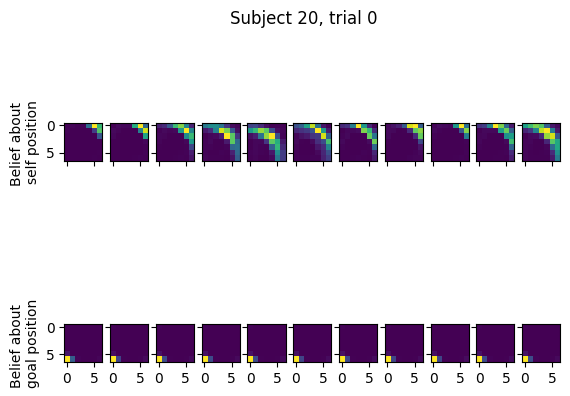

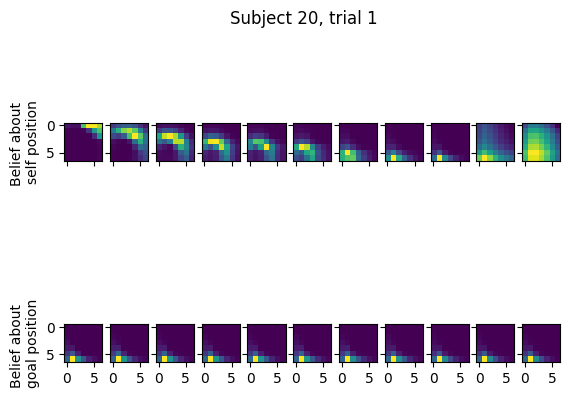

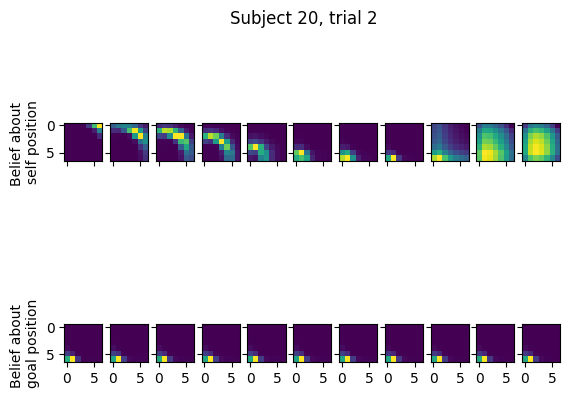

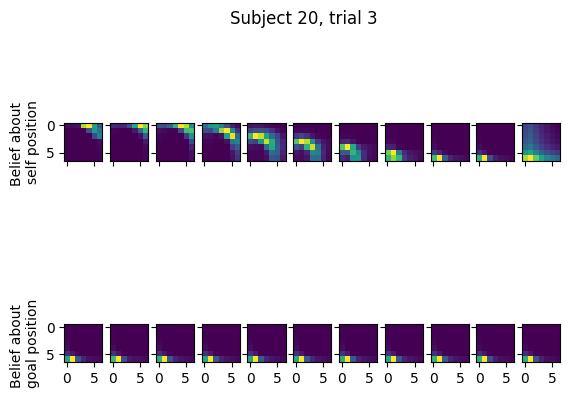

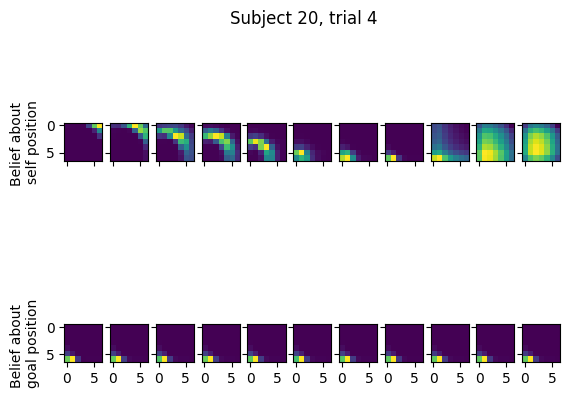

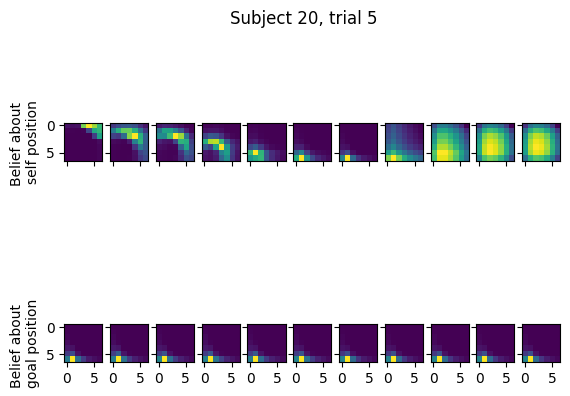

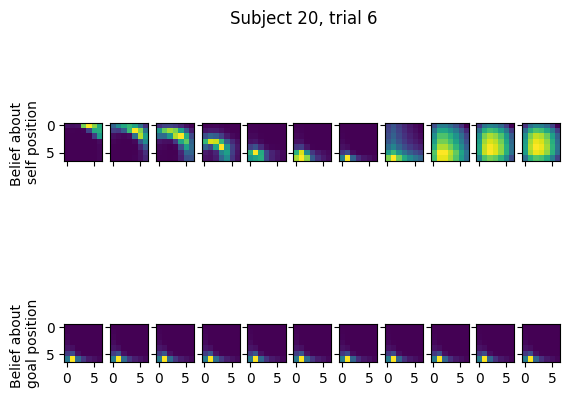

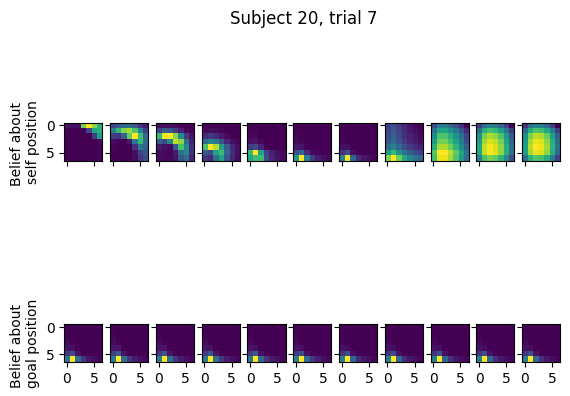

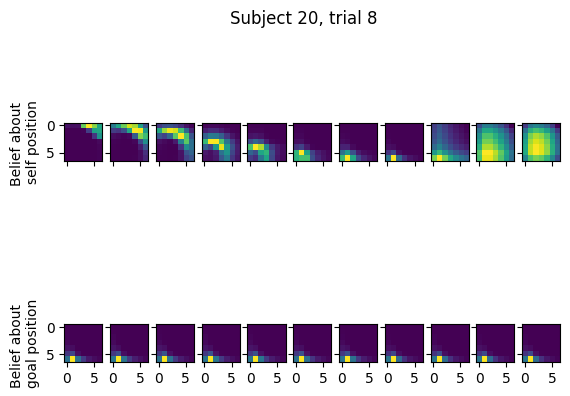

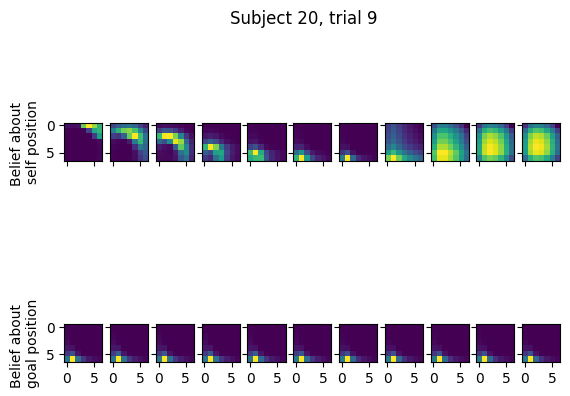

In [7]:
# The first step is to see how these interactions with the environment would change the models of each subject
# (perception & learning). 
# The broadest approximation for that would be recomputing the posteriors of the subject after each new observation !
from actynf import normalize
from actynf.jaxtynf.jax_toolbox import _normalize
from local_em import EM_jax
from models import to_jax
from generalize_helper import get_generalizing_table

subject_id = 20

obs = [observations_vect[subject_id,...]]
obs_filters = [observations_bool[subject_id,...]]
obs_u = actions_vect[subject_id,:-1,...] # Remove the last trial as it was not done with feedback
obs_u_filter = actions_bool[subject_id,:-1,...] # Remove the last trial as it was not done with feedback

alpha = 0.5
state_transition_generalizer = (lambda x : jnp.exp(-alpha*x))
action_transition_extrapolation_table = to_jax(get_generalizing_table(jnp.arange(u.shape[0]),"radial"))


# for trial in range(obs_u.shape[0]):
#         for timestep in range(obs_u.shape[1]):
#                 print(trial,timestep)
#                 smaller_data = observations_vect[subject_id,:trial+1,:timestep+1]
#                 print(smaller_data.shape)
(final_a,final_b,_,final_d),final_post,all_lls = EM_jax(obs,obs_filters,obs_u,obs_u_filter,
        a,b,d,u,
        N_iterations=7,
        lr_a=1.0,lr_b=1.0,lr_d=1.0,
        is_learn_a = False,is_learn_b = True,is_learn_d = True,
        state_generalize_function = state_transition_generalizer,
        action_generalize_table = action_transition_extrapolation_table,cross_action_extrapolation_coeff=0.2)

print(all_lls.shape)
print(np.round(np.array(all_lls[...,0]),2))
print(jnp.sum(all_lls[:,-1,:]))



def flex_norm(arr):
        return normalize(np.array(arr),all_axes=True)

Ntrials,Ntimesteps = final_post.shape[:2]
source_space_shape = a[0].shape[1:]
final_post = jnp.reshape(final_post, (Ntrials,Ntimesteps) + source_space_shape)

for trial in range(Ntrials):
    fig,axes = plt.subplots(2,Ntimesteps,sharey=True,sharex=True)
    
    
    axes[0,0].set_ylabel("Belief about \nself position")
    axes[1,0].set_ylabel("Belief about \ngoal position")
    for kt,t in enumerate(range(Ntimesteps)):
        this_timesteps_posterior = final_post[trial,t,...]
        
        ax_pos_raw = axes[0,t]
        ax_goal = axes[1,t]

        ax_pos_raw.imshow(flex_norm(np.sum(this_timesteps_posterior, axis=(2,3))))#,vmin=0.0,vmax=1.0)        
        
        ax_goal.imshow(flex_norm(np.sum(this_timesteps_posterior, axis=(0,1))))#,vmin=0.0,vmax=1.0)
        
        # axes[2,t].imshow(np.sum(STMs[trial+1][1].x
    fig.suptitle("Subject {}, trial {}".format(subject_id,trial))
    fig.show()

C:\Users\annic\AppData\Local\Temp\ipykernel_19824\2350737291.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_19824\2350737291.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


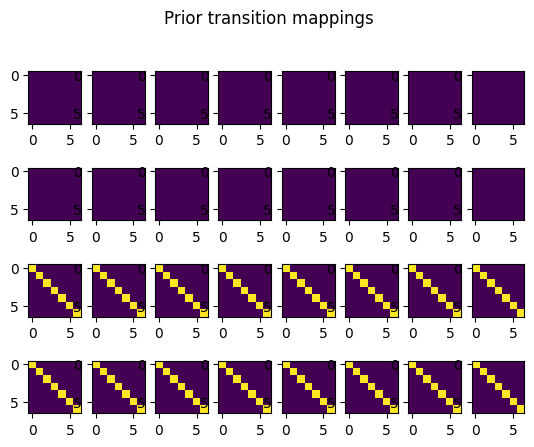

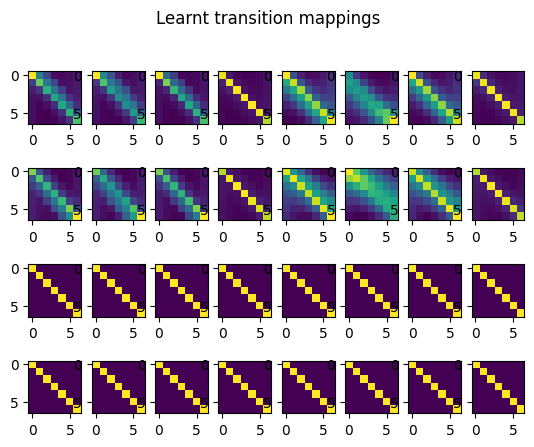

In [8]:


# goal_belief = np.sum(np.reshape(final_d,(3,3,3,3)),axis=(0,1))
# plt.imshow(goal_belief,vmin=0,vmax=1)
# plt.show()
# print(goal_belief)
# fig,ax = plt.subplots(1)
# ax.imshow(normalize(np.array(final_a[0])))
# fig.set_title("Learnt feedback mapping")
# fig.show()

Nf = len(final_b)
Nact = u.shape[0]


fig,axes = plt.subplots(Nf,Nact)
for factor in range(Nf):
        fig.suptitle("Prior transition mappings")
        Ntrans = final_b[factor].shape[-1]
        for transition in range(Ntrans):
                ax = axes[factor,transition]
                # print(normalize(np.array(final_b[0][:,:,0,0,act])))
                ax.imshow(normalize(np.array(b[factor][:,:,transition])))
fig.show()


fig,axes = plt.subplots(Nf,Nact)
for factor in range(Nf):
        fig.suptitle("Learnt transition mappings")
        Ntrans = final_b[factor].shape[-1]
        for transition in range(Ntrans):
                ax = axes[factor,transition]
                # print(normalize(np.array(final_b[0][:,:,0,0,act])))
                ax.imshow(normalize(np.array(final_b[factor][:,:,transition])))
fig.show()